<a href="https://colab.research.google.com/github/mbc2009/Lmp_ML/blob/main/Model_trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Enviornment Initialization

In [2]:
%%capture
%%bash

# remove unnecessary
rm -rf *

# update pip
python -m pip install --upgrade pip

# install package
pip install opencv-python pillow
pip install segmentation_models_pytorch
pip install -q kaggle
pip install dropbox
pip install scikit-image
pip install pandas openpyxl

In [3]:
# basic import
import  os, sys, time, math, random, math, psutil, h5py, re, pickle
from    datetime                import datetime
from    concurrent.futures      import ThreadPoolExecutor
from    typing                  import  List, Tuple
from    dropbox                 import  Dropbox
from    tqdm                    import  tqdm
from    mpl_toolkits.mplot3d    import  Axes3D
from    matplotlib              import  pyplot      as plt
import  numpy                                       as np
import  pandas                                      as pd
import  zipfile
import  warnings
import  shutil
import  joblib

from    sklearn.preprocessing   import MinMaxScaler
from    sklearn.metrics         import r2_score
from    skimage                 import  io
from    scipy                   import  interpolate
from    scipy.interpolate       import  RegularGridInterpolator
from    scipy.ndimage           import  generic_filter, rotate
from    PIL                     import  Image

import  torch
from    torch                   import  nn
from    torch.nn                import  functional  as F
import  torch.optim                                 as optim
import  torchvision.transforms.functional           as TF
from    torch.utils.data        import  Dataset, DataLoader, TensorDataset, random_split, Subset
from    torchvision             import  transforms, models
from    torchvision.transforms  import  *
import  kagglehub

In [4]:
# check hardware
print(f"CPU core #:\t{os.cpu_count()}")
print(f"CPU threads #:\t{psutil.cpu_count(logical=True)}")
print(f"Total memory:\t\t{psutil.virtual_memory().total / (1024**3):.2f} GB")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"available GPU #:\t{gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i+1}:\t\t{gpu_name}")
else:
    print("No available GPU")

CPU core #:	12
CPU threads #:	12
Total memory:		83.48 GB
available GPU #:	1
GPU 1:		NVIDIA A100-SXM4-40GB


# 1. Configuration

In [5]:
class Confuration():
  # define paths to directory
  home_dir                = os.path.expanduser("~")
  working_dir             = os.path.join(os.getcwd(),'Lmp_ML')
  DataBase_dir            = os.path.join(working_dir,'DataBase')
  DB_version              = 5
  DB_3D_Grids_density     = 128
  DB_3D_Grids_path        = os.path.join(DataBase_dir, f'{DB_version}', f'3D_Grids_{DB_3D_Grids_density}.h5') # TODO: choose database version, here ver=4
  DB_Excel_path           = os.path.join(working_dir,  f'LmpGP.xlsx')                                         # TODO: choose database version, here ver=4

  # dataset
  DB_items                = ['temp\n(k)',
                             'len\n(A)',
                             'density\n(g/cm^3)',
                             'pore_radius\n(A)',
                             'porosity\n(unitless)',
                             'bond_density\n(unitless)',
                             'specific_surface_area\n(m^2/g)',
                             #'tortuosity\n(unitless)'
                             'thermal_conductivity\n(W/(m·K))'
                             ]

  # debug
  dev_mode                = True

conf = Confuration()

In [6]:
# import code from git hub
!git clone https://github.com/mbc2009/Lmp_ML

Cloning into 'Lmp_ML'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 645 (delta 24), reused 0 (delta 0), pack-reused 601 (from 2)
Receiving objects: 100% (645/645), 154.32 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (301/301), done.


In [7]:
# make directory
os.makedirs(conf.DataBase_dir, exist_ok=True)

In [8]:
# download
original_path = kagglehub.dataset_download("mbc2009/heat-and-mass-transfer",force_download=True)
shutil.move(original_path, conf.DataBase_dir)

100%|██████████| 1.38G/1.38G [00:07<00:00, 198MB/s]

Extracting files...


'/content/Lmp_ML/DataBase/5'

# 2.Functions and Classes

In [9]:
def check_hdf5_content(file_path:str,PrintStrcut=False)->int:
  '''
  check the content (name, quantity) of hdf5 file
  input:
    file_path: the path of hdf5 file
    PrintStrcut: print the structure of hdf5 file
  return:
    the name and quantity of variables in hdf5 file
  '''
  # 初始化数据集计数器
  dataset_count = 0

  # 定义一个内部函数用于遍历 HDF5 文件内部
  def count_datasets(name, obj):
        nonlocal dataset_count
        if isinstance(obj, h5py.Dataset):  # 判断是否为数据集
            dataset_count += 1
        elif isinstance(obj, h5py.Group):  # 判断是否为组
            pass  # 如果是组，不计数

  with h5py.File(file_path, "r") as h5f:

        # 遍历文件内容以计数
        h5f.visititems(count_datasets)

        # 打印所有内变量名字
        if PrintStrcut:
          print(f"文件结构:")
          h5f.visit(print)

  print(f'文件数: {dataset_count}')

  return dataset_count # 文件数

# 3.Prepare Data Base

## 3.1. Prepare Excel Data Base

In [10]:
# convert Excel data into pandas data frame
df = pd.read_excel(conf.DB_Excel_path, engine="openpyxl")

In [11]:
if conf.dev_mode:
  # 打印形状
  print(df.shape)

  # 读取列名
  print(df.columns)

(836, 58)
Index(['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)',
       'density\n(g/cm^3)', 'density(rectified)\n(g/cm^3)',
       'thermal_conductivity\n(W/(m·K))',
       'thermal_conductivity(rectified)\n(W/(m·K))', 'mass\n(g)',
       'valume of box\n(A^3)', 'bond_density\n(unitless)',
       'thickness_of_box\n(A)', 'thickness_of_GP\n(A)', 'surface_area\n(A^2)',
       'specific_surface_area\n(m^2/g)', 'porosity\n(unitless)',
       'tortuosity\n(unitless)', 'pore_radius\n(A)', 'Unnamed: 18',
       'Diffusivity_Knudsen_PoreRadius\n(m^2/s)',
       'Diffusivity_Knudsen_peak\n(m^2/s)', 'Knudsen_number_PoreRadius',
       'Knudsen_number_peak', 'Unnamed: 23',
       'Diffusivity_EA_filtrates\n_in_membrane\n(m^2/s)',
       'Diffusivity_TA_filtrates\n_in_membrane\n(m^2/s)',
       'Diffusivity_EA_filtrates\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_TA_filtrates\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_EA_feeds\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_TA_feeds\n_i

In [12]:
if conf.dev_mode:
  # 筛选列名对应列
  df = df.loc[:, ['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)', 'density\n(g/cm^3)']]

In [13]:
def fetch_from_pandas(len_i: int, sigma_i: int, temp_i: int, items: List[str], df: pd.DataFrame) -> torch.Tensor:
    """
    根据 len_i, sigma_i, temp_i 在 pandas DataFrame 中查找指定 items，并返回一个 PyTorch Tensor。

    Args:
        len_i (int):        目标 len 值
        sigma_i (int):      目标 sigma 值
        temp_i (int):       目标 temp 值
        items (List[str]):  需要提取的列名列表
        df (pd.DataFrame):  数据源 Pandas DataFrame

    Returns:
        Optional[torch.Tensor]: 若找到数据，则返回一个 Float32 类型的 PyTorch Tensor，否则返回 None。
    """
    try:
        # 筛选符合条件的行，并提取多个列
        item_values = df.loc[
            (df["len\n(A)"] == len_i) &
            (df["sigma\n(A)"] == sigma_i) &
            (df["temp\n(k)"] == temp_i),
            items
        ]

        # 确保只有一行数据，转换为 Tensor
        if not item_values.empty:
            tensor_values = torch.tensor(item_values.values.flatten(), dtype=torch.float32)
            return tensor_values
        else:
            return None  # 没有匹配数据时返回 None

    except KeyError as e:
        print(f"列名错误: {e}")
        return None

    except ValueError as e:
        print(f"数据转换错误: {e}")
        return None

In [14]:
if conf.dev_mode:
  # 使用示例
  items = fetch_from_pandas(len_i= 2, sigma_i=8, temp_i=373, items=['density\n(g/cm^3)'], df=df)
  print(items[0].item())

0.37132611870765686


## 3.2.Check grid data base

In [15]:
if conf.dev_mode:
  # 查看hdf5文件内容
  num_grids = check_hdf5_content(conf.DB_3D_Grids_path,PrintStrcut=False)

文件数: 836


In [16]:
if conf.dev_mode:
  # 查看单个数据点
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]
  print(f'矩阵形状:   {GA.shape}')
  print(f'矩阵最大值: {np.max(GA)}')
  print(f'矩阵最小值: {np.min(GA)}')
  print(f"矩阵 GA 中 {np.max(GA)} 的数量：{np.count_nonzero(GA == np.max(GA)) }")

矩阵形状:   (128, 128, 128)
矩阵最大值: 3.0
矩阵最小值: 0.0
矩阵 GA 中 3.0 的数量：3


In [17]:
# 可视化函数
def plot_3D_Grid(matrix_3d):
    """
    绘制三维点阵的三视图（正视图、侧视图、俯视图）。

    Args:
        matrix_3d (numpy.ndarray): 三维点阵数据。

    Returns:
        None
    """
    # 创建图形和坐标轴
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 俯视图 (X-Y 平面)
    axes[0].imshow(np.sum(matrix_3d, axis=0), cmap='viridis')  # 沿 Z 轴求和
    axes[0].set_title('Top View (X-Y)')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # 正视图 (Z-X 平面)
    axes[1].imshow(np.sum(matrix_3d, axis=1), cmap='viridis')  # 沿 Y 轴求和
    axes[1].set_title('Front View (Z-X)')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('X')

    # 侧视图 (Z-Y 平面)
    axes[2].imshow(np.sum(matrix_3d, axis=2), cmap='viridis')  # 沿 X 轴求和
    axes[2].set_title('Side View (Z-Y)')
    axes[2].set_xlabel('Z')
    axes[2].set_ylabel('Y')

    # 显示图形
    plt.show()

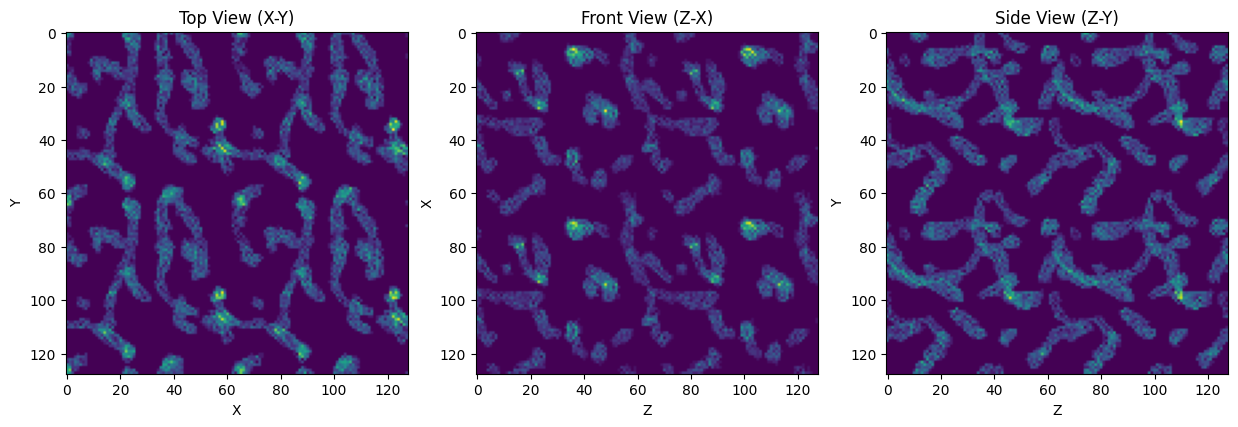

In [18]:
if conf.dev_mode:
  plot_3D_Grid(GA)  # 将 GA 替换为你的三维点阵数据

## 3.3.Home-brewing dataset

In [19]:
class myDataBase(Dataset):
    def __init__(self,
                 hdf5_3D_Grids_file_path:str,
                 excel_Performance_and_Properties_file_path:str):
        '''
        name:  'len_{i}_sigma_{j}_temp_{k}'
        label: [len_i, sigma_i, temp_i], type: pytorch tensor
        structure: 3D grid, type: pytorch tensor
        '''
        ## GRID
        # 3D grids (h5py file)
        self.grids_hdf5     = h5py.File(hdf5_3D_Grids_file_path, 'r')
        # Sorted name list of all GA structures (h5py file)
        self.data_NameList  = self.sort_NameList((self.grids_hdf5.keys()))

        ## EXCEL
        # Performance & Properties (Excel => PD)
        self.PnP_pd = pd.read_excel(excel_Performance_and_Properties_file_path, engine="openpyxl")
        self.PnP_pd = self.PnP_pd

        # Normalize PD file
        self.scaler           = MinMaxScaler()
        self.PnP_pd_selected  = self.PnP_pd[conf.DB_items].copy()                # Select desired columns from the original DataFrame
        self.PnP_pd_scaled    = self.scaler.fit_transform(self.PnP_pd_selected)  # Scale the selected data
        self.PnP_pd_scaled    = pd.DataFrame(self.PnP_pd_scaled,                 # Convert to DataFrame
                                          columns=self.PnP_pd_selected.columns)


        joblib.dump(self.scaler, "scaler.pkl")  # 保存 scaler（用于推理时 inverse_transform 反归一化）
        print('Scaler Saved')

    def __len__(self):
        return len(self.data_NameList)

    def __getitem__(self, index):
        ## 1. Index ##
        # 解析: index -> str
        name_i      = self.data_NameList[index]

        # 转换: str -> list [len_i, sigma_i, temp_i] -> tensor
        label_i     = self.extract_label_from_key(name_i)

        ## 2. GRIDS ##
        # 提取 (hdf5 => np.ndarray)
        grid_i      = self.grids_hdf5[name_i][:]
        # 转换: Grids (np.ndarray -> PyTorch tensor)
        grid_i      = torch.from_numpy(grid_i)

        ## 3. EXCEL ##
        # find row index
        pd_idx   = self.seek_idx_from_pandas(len_i=label_i[0],
                                            sigma_i=label_i[1],
                                            temp_i=label_i[2],
                                            items=conf.DB_items,
                                            df=self.PnP_pd)
        # Pandas => tensor ([item1,item2,item3...]
        items_i  = self.PnP_pd_scaled.iloc[pd_idx]
        items_i  = torch.tensor(items_i.values, dtype=torch.float32)

        ## 4. 返回
        return torch.tensor(label_i), grid_i, items_i

    def close(self):
         # 关闭h5文件，防止损坏
        self.grids_hdf5.close()

    def extract_label_from_key(self, name:str):
        # 解析数据点名称为三维张量
        len_val   = int(name.split('_')[1])
        sigma_val = int(name.split('_')[3])
        temp_val  = int(name.split('_')[-1])
        label_i   = [len_val, sigma_val, temp_val]
        return label_i

    def seek_idx_from_pandas(self, len_i:int, sigma_i:int, temp_i:int, items:List[str], df: pd.DataFrame) -> torch.Tensor:
        # ... (other parts of the function remain the same) ...

        try:
            item_idx = df.loc[
                (df["len\n(A)"]   == len_i) &
                (df["sigma\n(A)"] == sigma_i) &
                (df["temp\n(k)"]  == temp_i),
                items
            ].index

            # Check if item_idx is empty before accessing element 0
            if len(item_idx) > 0:
                return item_idx[0]
            else:
                # Handle the case where no matching rows are found
                print(f"Warning: No matching rows found for len={len_i}, sigma={sigma_i}, temp={temp_i}: {item_idx}")
                return -1 # or raise ValueError("No matching rows found")

        except KeyError as e:
            print(f"列名错误: {e}")
            return None

        except ValueError as e:
            print(f"数据转换错误: {e}")
            return None

    def sort_NameList(self, strings:str):
        # 数据点列表名称排序
        def key_func(s):
            match = re.match(r"len_(\d+)_sigma_(\d+)_(\d+)", s)  # 提取数字
            if match:
                len_val, sigma_val, temp_val = map(int, match.groups())
                return (len_val, sigma_val, -temp_val)  # 第三个数字取反，实现降序
            else:
                return (float('inf'), float('inf'), float('-inf'))  # 处理不匹配的情况
        return sorted(strings, key=key_func)  # 排序


In [20]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # 读取
  label_i, grid_i, items_i  = dataset[0]
  dataset.close() # 关闭读取

  # 打印
  print(f'{label_i}\t\t{type(label_i)}\n{grid_i.shape}\t{type(grid_i)}\n{items_i}\t{type(items_i)}')

Scaler Saved
tensor([  2,   8, 373])		<class 'torch.Tensor'>
torch.Size([128, 128, 128])	<class 'torch.Tensor'>
tensor([1.0000, 0.0000, 0.4127, 0.0171, 0.8493, 0.9259, 0.8402, 1.0000])	<class 'torch.Tensor'>


In [21]:
if conf.dev_mode:
  print(dataset.PnP_pd)#.to_string())

     len\n(A)  sigma\n(A)  temp\n(k)  flux\n(L/m^2/h)  density\n(g/cm^3)  \
0           2           8        373              NaN           0.371326   
1           2           9        373              NaN           0.285173   
2           2          10        373     18584.217880           0.251141   
3           2          11        373     23078.338958           0.250895   
4           2          12        373     15145.808882           0.162353   
..        ...         ...        ...              ...                ...   
831        20          14        343      1007.259785           0.459294   
832        20          15        343      3085.739501           0.415420   
833        20          16        343      1452.821398           0.376631   
834        20          17        343      4174.287072           0.348876   
835        20          18        343      2755.743841           0.317294   

     density(rectified)\n(g/cm^3)  thermal_conductivity\n(W/(m·K))  \
0                

In [22]:
if conf.dev_mode:
  print(dataset.PnP_pd_scaled.to_string())

     temp\n(k)  len\n(A)  density\n(g/cm^3)  pore_radius\n(A)  porosity\n(unitless)  bond_density\n(unitless)  specific_surface_area\n(m^2/g)  thermal_conductivity\n(W/(m·K))
0     1.000000  0.000000           0.412701          0.017101              0.849326                  0.925863                        0.840166                         1.000000
1     1.000000  0.000000           0.312417          0.027700              0.877045                  0.832090                        0.712540                         0.277160
2     1.000000  0.000000           0.272802          0.035101              0.859019                  0.776186                        0.611166                         0.126553
3     1.000000  0.000000           0.272516          0.035038              0.800843                  0.775284                        0.596687                         0.197369
4     1.000000  0.000000           0.169450          0.066101              0.867280                  0.739217                

In [23]:
if conf.dev_mode:
  # 查看文件名列表
  # 长度
  print(len(dataset.data_NameList))

  # 内容
  for i in dataset.data_NameList:
      print(i)
  dataset.close() # 关闭读取

836
len_2_sigma_8_373
len_2_sigma_8_363
len_2_sigma_8_353
len_2_sigma_8_343
len_2_sigma_9_373
len_2_sigma_9_363
len_2_sigma_9_353
len_2_sigma_9_343
len_2_sigma_10_373
len_2_sigma_10_363
len_2_sigma_10_353
len_2_sigma_10_343
len_2_sigma_11_373
len_2_sigma_11_363
len_2_sigma_11_353
len_2_sigma_11_343
len_2_sigma_12_373
len_2_sigma_12_363
len_2_sigma_12_353
len_2_sigma_12_343
len_2_sigma_13_373
len_2_sigma_13_363
len_2_sigma_13_353
len_2_sigma_13_343
len_2_sigma_14_373
len_2_sigma_14_363
len_2_sigma_14_353
len_2_sigma_14_343
len_2_sigma_15_373
len_2_sigma_15_363
len_2_sigma_15_353
len_2_sigma_15_343
len_2_sigma_16_373
len_2_sigma_16_363
len_2_sigma_16_353
len_2_sigma_16_343
len_2_sigma_17_373
len_2_sigma_17_363
len_2_sigma_17_353
len_2_sigma_17_343
len_2_sigma_18_373
len_2_sigma_18_363
len_2_sigma_18_353
len_2_sigma_18_343
len_3_sigma_8_373
len_3_sigma_8_363
len_3_sigma_8_353
len_3_sigma_8_343
len_3_sigma_9_373
len_3_sigma_9_363
len_3_sigma_9_353
len_3_sigma_9_343
len_3_sigma_10_373
len_3

## 3.4. Data augmentation

In [24]:
def rotate_3D_Grid(matrix_3d: np.ndarray, angle_degrees: float):
    """
    绕穿过 x-y 平面的中心点且平行于 z 轴的轴旋转三维矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。
        angle_degrees (float): 旋转角度（以度为单位，默认逆时针）。

    Returns:
        numpy.ndarray: 旋转后的三维矩阵。
    """
    rotated_matrix = rotate(matrix_3d,
                            angle=-angle_degrees,  # 顺时针旋转
                            axes=(1, 2),  # 旋转 x-y 平面，即绕 z 轴旋转
                            reshape=False,
                            order=0,
                            mode='constant',
                            cval=0)
    return rotated_matrix

def multi_threaded_rotation(matrix_3d: np.ndarray):
    """
    并行计算 90°, 180°, 270° 三种旋转后的 3D 矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。

    Returns:
        dict: 包含 90°, 180°, 270° 旋转后的矩阵。
    """
    angles          = [90, 180, 270]
    rotated_results = {}

    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(rotate_3D_Grid, [matrix_3d]*3, angles)

    # 存储旋转后的矩阵
    for angle, rotated_matrix in zip(angles, results):
        rotated_results[f"rotate_{angle}"] = rotated_matrix

    return rotated_results

(5, 3, 3) (5, 3, 3) (5, 3, 3)


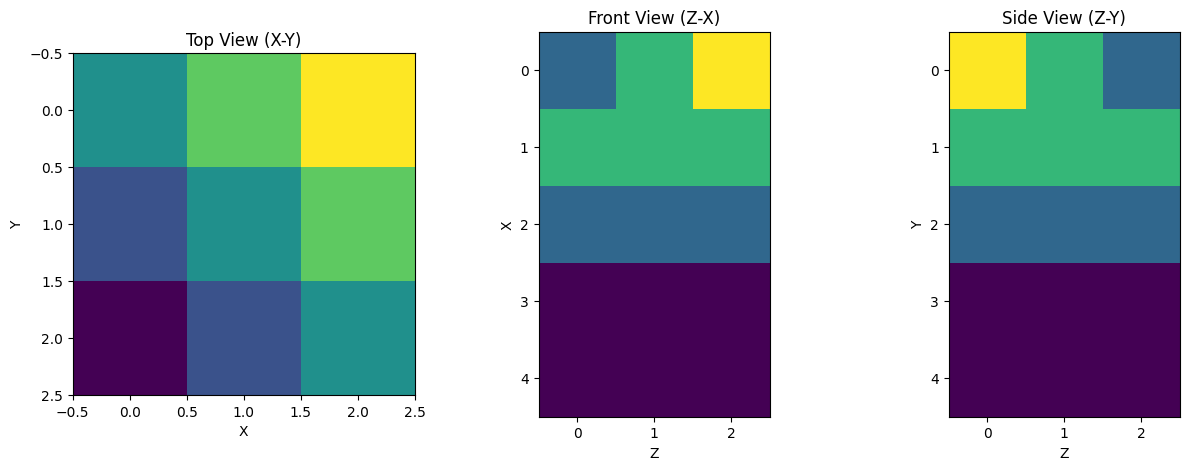

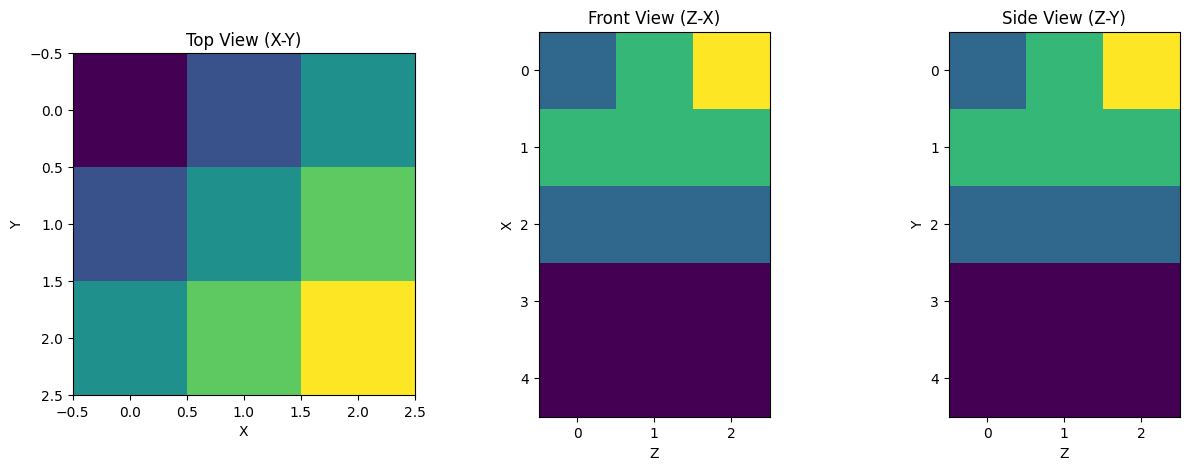

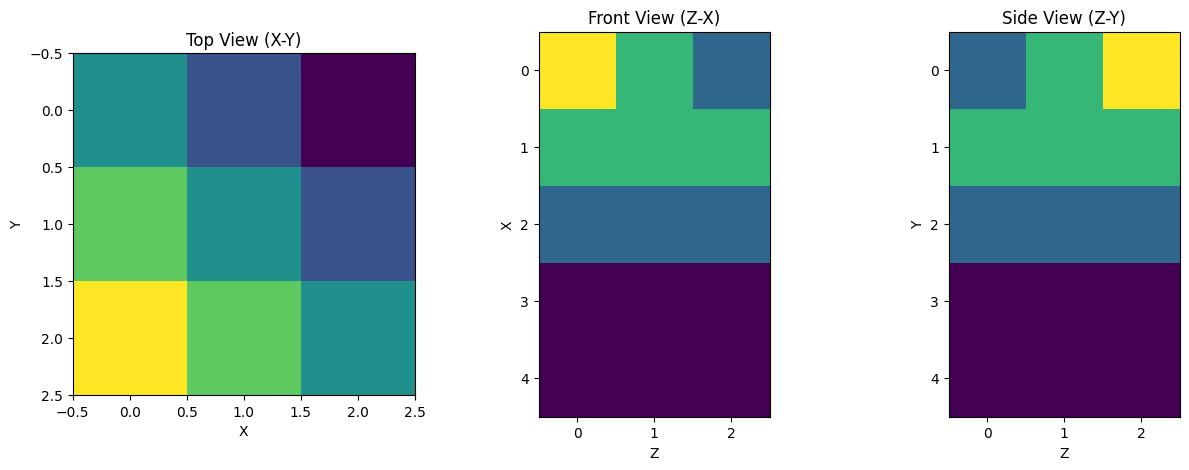

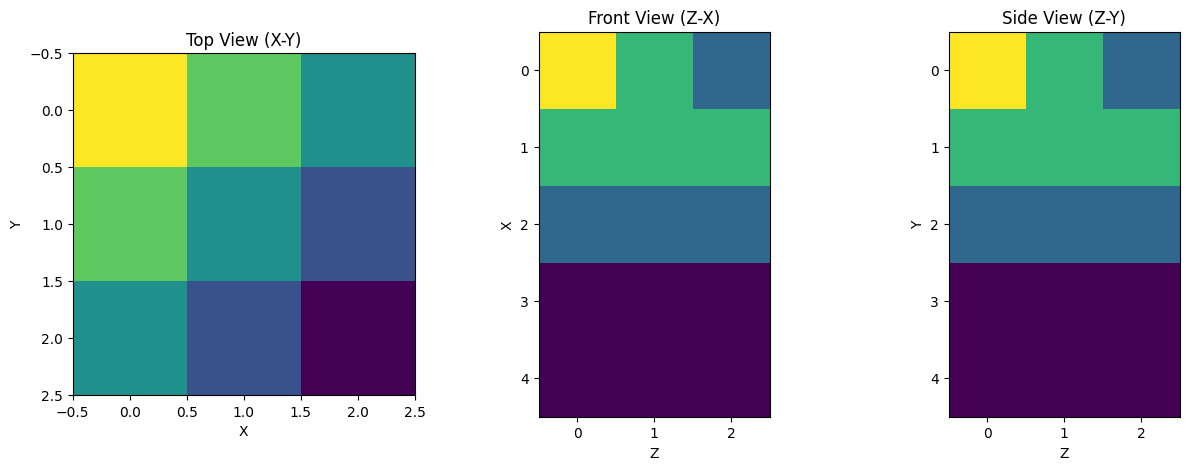

In [25]:
if conf.dev_mode:
  # simple case
  GA = np.asarray([
                  [[2,3,4],  # z = 3
                  [1,2,3],
                  [0,1,2]],
                  [[2,2,2],   # z = 3
                  [2,2,2],
                  [2,2,2]],
                  [[1,1,1],   # z = 2
                  [1,1,1],
                  [1,1,1]],
                  [[0,0,0],   # z = 1
                  [0,0,0],
                  [0,0,0]],
                  [[0,0,0],   # z = 0
                  [0,0,0],
                  [0,0,0]]]
                  )

  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

(128, 128, 128) (128, 128, 128) (128, 128, 128)


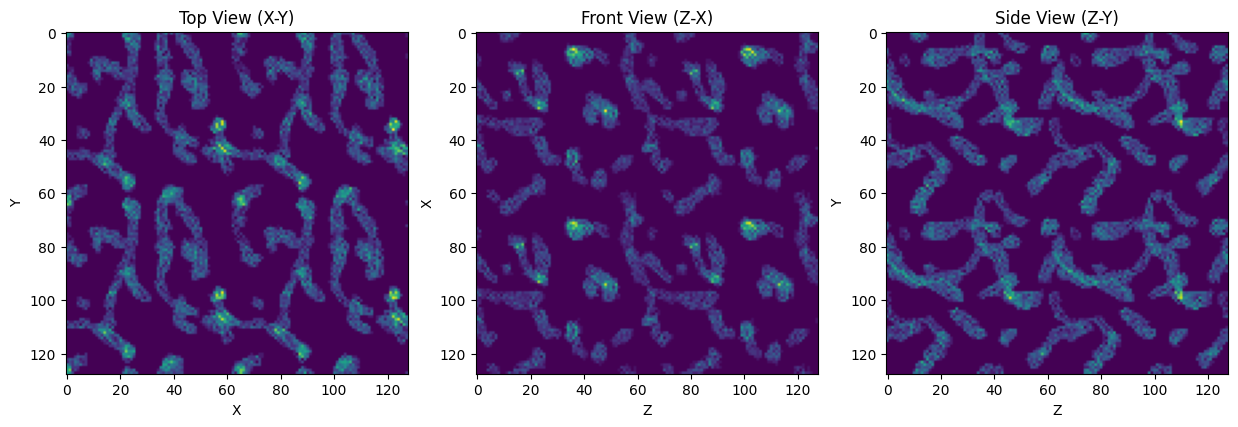

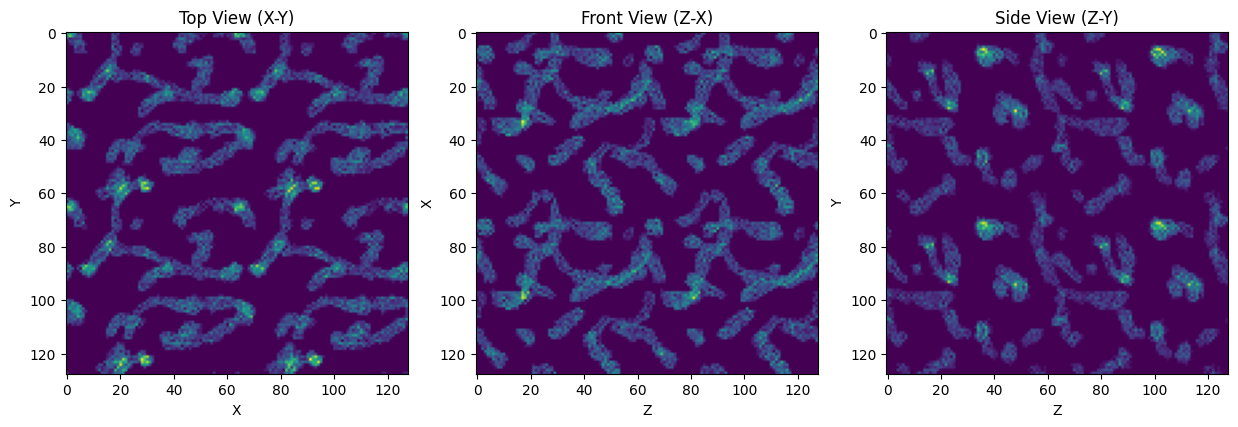

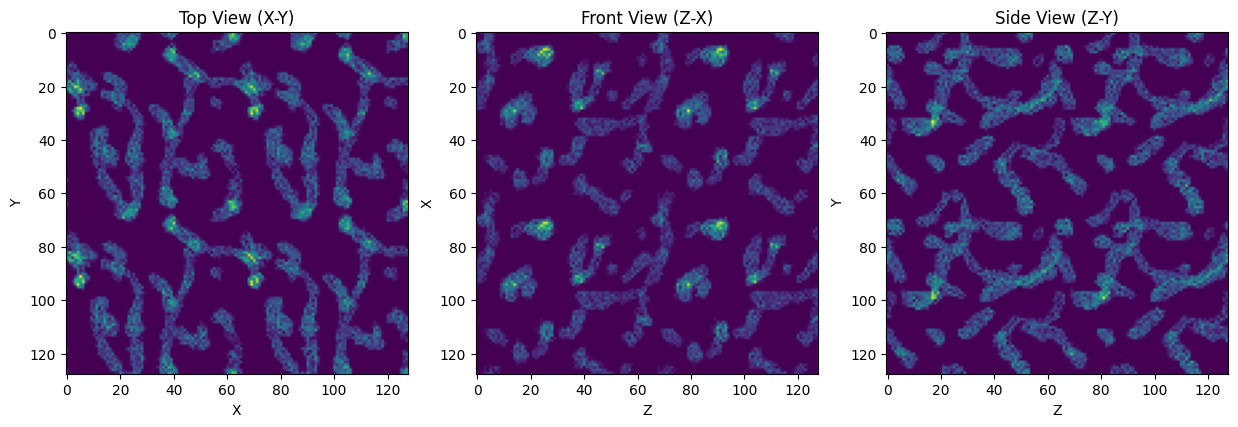

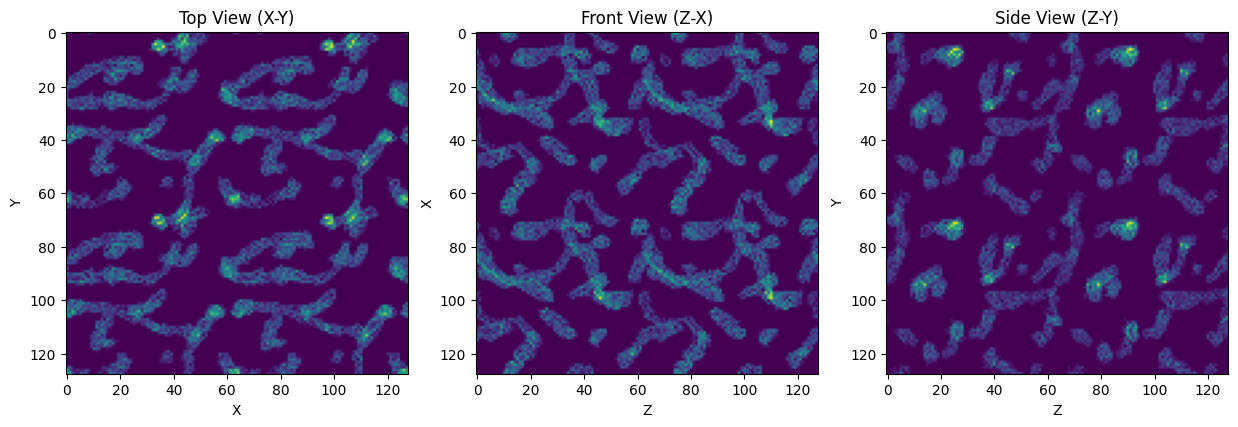

In [26]:
if conf.dev_mode:
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]


  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [27]:
class RotatedDataBase(myDataBase):
    """
    3D 矩阵旋转数据集，返回 90°, 180°, 270° 旋转后的矩阵。
    """
    def __init__(self, base_dataset):
        """
        初始化数据集。

        Args:
            data_list (list of np.ndarray): 原始 3D 矩阵列表，每个矩阵 shape=(400,400,400)。
        """
        self.base_dataset     = base_dataset                # 原始数据集
        self.rotation_angles  = [0, 90, 180, 270]           # 旋转角度
        self.num_rotations    = len(self.rotation_angles)   # 旋转次数
        #self.data_NameList    = base_dataset.data_NameList  # 数据点列表名称

    def __len__(self):
        """
        数据集大小
        """
        return int(len(self.base_dataset)*(self.num_rotations))

    def __getitem__(self, new_idx):
        """
        获取数据并返回旋转后的4个版本
        Returns:
            dict: {"original":   原始 3D 矩阵,
                   "rotate_90":  顺时旋转 90°,
                   "rotate_180": 顺时旋转 180°,
                   "rotate_270": 顺时旋转 270°}
        """
        # 计算index
        rotation_idx    = new_idx %  (self.num_rotations)  # index within the rotation group
        original_idx    = new_idx // (self.num_rotations)  # index in the oringal base dataset

        # 原始矩阵
        label_i, grid_i, items_i  = self.base_dataset[original_idx]

        # 旋转
        rotated_grid_i = rotate_3D_Grid(matrix_3d=grid_i, angle_degrees=self.rotation_angles[rotation_idx])

        # 确保转换为 float32 的 PyTorch Tensor
        rotated_grid_i = torch.from_numpy(rotated_grid_i).to(torch.float32)

        # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
        #rotated_grid_i = rotated_grid_i.unsqueeze(0)

        # 返回
        return  label_i, rotated_grid_i, items_i

In [28]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # Augmentation
  rotated_dataset = RotatedDataBase(dataset)

  for idx in [0,1,2,3]:
    idx += (11*4)
    print(idx)
    label_i, grid_i, items_i = rotated_dataset[idx]

    print(f'check-{dataset.data_NameList[idx//4]}')

    print(label_i, grid_i.shape, items_i)
    print(type(grid_i))

Scaler Saved
44
check-len_2_sigma_10_343
tensor([  2,  10, 343]) torch.Size([128, 128, 128]) tensor([0.0000, 0.0000, 0.2728, 0.0351, 0.8590, 0.7762, 0.6112, 0.1247])
<class 'torch.Tensor'>
45
check-len_2_sigma_10_343
tensor([  2,  10, 343]) torch.Size([128, 128, 128]) tensor([0.0000, 0.0000, 0.2728, 0.0351, 0.8590, 0.7762, 0.6112, 0.1247])
<class 'torch.Tensor'>
46
check-len_2_sigma_10_343
tensor([  2,  10, 343]) torch.Size([128, 128, 128]) tensor([0.0000, 0.0000, 0.2728, 0.0351, 0.8590, 0.7762, 0.6112, 0.1247])
<class 'torch.Tensor'>
47
check-len_2_sigma_10_343
tensor([  2,  10, 343]) torch.Size([128, 128, 128]) tensor([0.0000, 0.0000, 0.2728, 0.0351, 0.8590, 0.7762, 0.6112, 0.1247])
<class 'torch.Tensor'>


In [29]:
# loader speed test
if False:

  def load_data_item(dataset, index):
      """
      加载单个数据项
      """
      _, _, _ = dataset[index]


  def calculate_loading_time_multithreaded(dataset, num_threads=4):
      """使用多线程计算加载数据集所需的时间。"""
      start_time = time.time()

      with ThreadPoolExecutor(max_workers=num_threads) as executor:
          # 创建任务列表，每个任务加载一个数据项
          tasks = [executor.submit(load_data_item, dataset, i) for i in range(len(dataset))]

          # 使用 tqdm 显示进度条，并等待所有任务完成
          for _ in tqdm(tasks, total=len(tasks), desc="多线程加载数据集..."):
              _.result()  # 获取任务结果，以确保任务已完成

      end_time = time.time()
      total_time = end_time - start_time

      return total_time


  # 创建数据集
  dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)
  rotated_dataset = RotatedDataBase(dataset)

  # 计算并打印加载时间
  loading_time = calculate_loading_time_multithreaded(rotated_dataset, num_threads=int(psutil.cpu_count(logical=True)))
  print(f"使用多线程加载整个 rotated_dataset 所需时间：{loading_time:.2f} 秒")

# 4.Model Preparation

In [30]:

class Pure3DCNN(nn.Module):
    def __init__(self):
        super(Pure3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        # 由于去掉 Transformer，fc1 之后直接进入 fc2
        self.fc1 = nn.Linear(32 * 32 * 32 * 32, 128)  # CNN 提取的特征
        self.fc2 = nn.Linear(128 + 1, 64)  # 额外加入 temp_i（1 维）
        self.output_dim = len(conf.DB_items) - 1  # 计算输出维度
        self.fc3 = nn.Linear(64, self.output_dim)  # 最终输出层

    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)  # 展平

        x = F.relu(self.fc1(x))  # fc1 out: CNN 特征提取

        temp_i  = tensor_i.unsqueeze(1)  # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)  # 拼接 temp_i

        x = F.relu(self.fc2(x))  # fc2 out: relu
        x = self.fc3(x)  # fc3 out: 输出最终结果
        return x

In [31]:
class ViT3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(ViT3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # 额外加入 temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # 恢复 batch 维度
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Swin3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(Swin3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # 额外加入 temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # 恢复 batch 维度
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征
        self.fc2          = nn.Linear(128 + 1, 64)          # 只加入 temp_i（1 维）
        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension
        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items


    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)     # 展平

        x = F.relu(self.fc1(x))             # fc1 out: CNN 特征提取
        x = x.unsqueeze(0)                  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)             # 通过 Transformer 处理
        x = x.squeeze(0)                    # 恢复 batch 维度

        temp_i  = tensor_i.unsqueeze(1)            # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # 拼接 temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: 输出最终结果
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer   = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)

# 5.Load Data

In [33]:
# 设定训练集和测试集比例
train_ratio = 0.8  # 80% 训练集, 20% 测试集

# 读取原始数据
dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)

# 计算划分数量
train_size = int(train_ratio * len(dataset))
test_size  = len(dataset) - train_size

# 先在 原始数据 上进行划分
indices = list(range(len(dataset)))  # 原始数据索引
train_indices, test_indices = random_split(indices, [train_size, test_size])

# 创建训练集和测试集的 Subset
train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

Scaler Saved


In [34]:
# 增强训练集
train_dataset_augmented = RotatedDataBase(train_dataset)
# 增强测试集
test_dataset_augmented  = RotatedDataBase(test_dataset)

In [35]:
# 生成 DataLoader
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=psutil.cpu_count(logical=True))
test_loader  = DataLoader(test_dataset_augmented,  batch_size=32, shuffle=False, num_workers=psutil.cpu_count(logical=True))

print(f"训练集大小: {len(train_dataset_augmented)}, 测试集大小: {len(test_dataset)}")

训练集大小: 2672, 测试集大小: 168


# 6.Model Trainning

In [36]:
# initialization
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model           = Improved3DCNN().to(device)
criterion       = nn.MSELoss()

torch.cuda.empty_cache() # 清理缓存

def model_train(num_epochs:int, learning_rate:float):
  model.train() # 训练模式
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(num_epochs):
      running_loss = 0.0
      for label, grid, items in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
          label, grid, items = label.to(device), grid.to(device), items.to(device)
          grid  = grid.unsqueeze(1)  # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
          optimizer.zero_grad()      # 清零 梯度
          output = model(grid, items[:, 0])  # TODO: 确保 输入grid + temp_i, 前向传播
          loss   = criterion(output, items[:, 1:]) # TODO: 确保 输入 temp_i 以后的
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [37]:
# Trainning: stage-1
train_start_time = time.time() # 记录时间
model_train(num_epochs=10,learning_rate=0.0002) # 训练

torch.save(model.state_dict(), "3d_cnn_model.pth") # save

print("✅ 模型训练完成，已保存！")

Epoch 1/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 1/10, Loss: 0.0496


Epoch 2/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 2/10, Loss: 0.0100


Epoch 3/10: 100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


Epoch: 3/10, Loss: 0.0041


Epoch 4/10: 100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


Epoch: 4/10, Loss: 0.0026


Epoch 5/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 5/10, Loss: 0.0018


Epoch 6/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 6/10, Loss: 0.0013


Epoch 7/10: 100%|██████████| 84/84 [00:59<00:00,  1.40it/s]


Epoch: 7/10, Loss: 0.0012


Epoch 8/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 8/10, Loss: 0.0009


Epoch 9/10: 100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


Epoch: 9/10, Loss: 0.0008


Epoch 10/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 10/10, Loss: 0.0006
✅ 模型训练完成，已保存！


Note:\
As TC added, 4$e^{-4}$ shows gradient disapper (loss:Nan)\
$\therefore$ 4$e^{-4}$ $\rightarrow$ 2$e^{-4}$

In [38]:
## Trainning: stage-2
model.load_state_dict(torch.load("3d_cnn_model.pth")) # load model
model_train(num_epochs=10,learning_rate=0.0001) # train

torch.save(model.state_dict(), "3d_cnn_model_v2.pth") # 再次保存模型
train_end_time = time.time() # 记录时间
trainning_time = train_end_time - train_start_time # 计算训练时间

print("✅ 继续训练完成，已保存为 `3d_cnn_model_v2.pth`")
print(f"🕛 训练耗时: {trainning_time:.3f} 秒")

<ipython-input-38-320f546a447e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("3d_cnn_model.pth")) # load model
Epoch 1/10: 100%|████████

Epoch: 1/10, Loss: 0.0013


Epoch 2/10: 100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


Epoch: 2/10, Loss: 0.0005


Epoch 3/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 3/10, Loss: 0.0005


Epoch 4/10: 100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


Epoch: 4/10, Loss: 0.0004


Epoch 5/10: 100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


Epoch: 5/10, Loss: 0.0004


Epoch 6/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 6/10, Loss: 0.0004


Epoch 7/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 7/10, Loss: 0.0004


Epoch 8/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 8/10, Loss: 0.0004


Epoch 9/10: 100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


Epoch: 9/10, Loss: 0.0003


Epoch 10/10: 100%|██████████| 84/84 [01:00<00:00,  1.39it/s]


Epoch: 10/10, Loss: 0.0003
✅ 继续训练完成，已保存为 `3d_cnn_model_v2.pth`
🕛 训练耗时: 1210.538 秒


# 7.Model Reasoning

In [39]:
# 加载模型
model = Improved3DCNN().to(device)                        # Create an instance of your model
model.load_state_dict(torch.load('3d_cnn_model_v2.pth'))  # Load the saved state_dict
model.eval()                                              # Set the model to evaluation mode

# 用于存储预测值和真实值
predictions_scaled   = []
actual_values_scaled = []

# 用于存储总的损失
total_loss    = 0.0
criterion     = nn.MSELoss()

# 推理
reasoning_start_time = time.time() # 记录时间
with torch.no_grad():
    for label, grid, items in tqdm(test_loader, desc=f"Evaluating..."): # Changed description
        label, grid, items = label.to(device), grid.to(device), items.to(device)
        grid    = grid.unsqueeze(1)               # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
        output  = model(grid, items[:, 0])        # TODO: 确保 输入grid + temp_i, 前向传播
        loss    = criterion(output, items[:, 1:]) # TODO: 确保 输入 temp_i 以后的
        total_loss += loss.item()

        # Append predictions and actual values to the lists
        predictions_scaled.extend(output.cpu())         # Move predictions to CPU
        actual_values_scaled.extend(items[:, 1:].cpu()) # Move actual values to CPU

reasoning_end_time = time.time() # 记录时间
reasoning_time = reasoning_end_time - reasoning_start_time # 计算推理时间
print(f"🕛 推理耗时: {reasoning_time:.3f} 秒")
print(f"Test Loss: {total_loss / len(test_loader):.4f}")

<ipython-input-39-197bf091bac0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('3d_cnn_model_v2.pth'))  # Load the saved state_dict
Evalua

🕛 推理耗时: 16.717 秒
Test Loss: 0.0003


# 8.Model Evaluation

In [40]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
import scipy.stats

**📌 8.1 绝对误差 (MAE - Mean Absolute Error)**
$$
\text{MAE} = \frac{1}{n} \sum |y_{true} - y_{pred}|
$$

- 衡量模型预测误差的平均绝对值。
- 与 MSE 相比，MAE 不会放大较大的误差，对异常值（outliers）更鲁棒。

In [41]:
MAE = mean_absolute_error(actual_values_scaled, predictions_scaled)
print(f"📉 MAE: {MAE:.4f}")

📉 MAE: 0.0116


**📌 8.2 均方误差(MSE - Mean Squared Error)**
$$
\text{MSE} = \frac{1}{n} \sum \left(y_{true} - y_{pred}\right)^2
$$

- 衡量模型预测误差的平方平均值，放大较大误差，对异常值敏感。


In [42]:
MSE = mean_squared_error(actual_values_scaled, predictions_scaled)
print(f"📉 MSE: {MSE:.4f}")

📉 MSE: 0.0003


**📌 8.3. 均方根误差(RMSE - Root Mean Squared Error)**
$$
RMSE = \sqrt{MSE}
$$

- RMSE = MSE 开平方，单位与原变量一致，更易解释。

In [43]:
RMSE = np.sqrt(MSE)
print(f"📉 RMSE: {RMSE:.4f}")

📉 RMSE: 0.0161


**📌 8.4 平均百分比误差(MAPE - Mean Absolute Percentage Error)**
$$
MAPE = \frac{1}{n} \sum \left| \frac{y_{true} - y_{pred}}{y_{true}} \right| x 100 \text{%}
$$

- 衡量预测误差相对于真实值的百分比，适用于不同尺度的数据。
- ⚠️ 适用于非负数据，否则可能会报错。


In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(np.array(actual_values_scaled), np.array(predictions_scaled))
print(f"📉 MAPE: {MAPE:.2f}%")

📉 MAPE: inf%


<ipython-input-44-52ec4e328dbf>:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


**📌 8.5 解释方差得分(Explained Variance Score)**
$$
EVS = 1 - \frac{Var(y_{true}-y_{pred})}{Var(y_{true})}
$$

- 衡量模型对数据方差的解释能力，类似 R²，但不受数据缩放影响。

In [45]:
EVS = explained_variance_score(actual_values_scaled, predictions_scaled)
print(f"📊 Explained Variance Score: {EVS:.4f}")

📊 Explained Variance Score: 0.9971


**📌 8.6 平均对数误差(MSLE - Mean Squared Logarithmic Error)**
$$
\text{MSLE} = \frac{1}{n} \sum \left( \log(1 + y_{\text{true}}) - \log(1 + y_{\text{pred}}) \right)^2
$$

- 适用于预测值变化范围较大的情况（如预测收入、人口等）。
- 避免极端值影响，更关注相对误差。
- ⚠️ 适用于非负数据，否则可能会报错。


In [46]:
MSLE = mean_squared_log_error(actual_values_scaled, predictions_scaled)
print(f"📉 MSLE: {MSLE:.4f}")

📉 MSLE: 0.0001


**📌 8.7 皮尔逊相关系数（Pearson Correlation Coefficient）**
$$
\text{PCC} = \frac{\text{Cov}(y_{\text{true}}, y_{\text{pred}})}{\sigma_{y_{\text{true}}} \cdot \sigma_{y_{\text{pred}}}}
$$

- 衡量预测值和真实值之间的线性相关性，范围在 \([-1,1]\) 之间：
  - **+1** 表示完全正相关
  - **0** 表示无相关性
  - **-1** 表示完全负相关


In [49]:
PCC, _ = scipy.stats.pearsonr(np.array(actual_values_scaled).flatten(), np.array(predictions_scaled).flatten())
print(f"📈 Pearson Correlation Coefficient: {PCC:.4f}")

📈 Pearson Correlation Coefficient: 0.9986


**📌 8.7 方误差($R^{2}$ )**
**R² 公式**

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

其中：

- $SS$ = Sum of Squares
- $SS_{res} = \sum (y_{\text{true}} - y_{\text{pred}})^2$ —— 残差平方和
- $SS_{tot} = \sum (y_{\text{true}} - \bar{y}_{\text{true}})^2$ —— 总平方和
- $\bar{y}_{\text{true}}$ 是真实值的均值。

**R² 的解释**

- **\( R^2 = 1.0 \)**：模型完美拟合数据。
- **\( 0 < R^2 < 1 \)**：模型有一定的解释能力，但仍有误差。
- **\( R^2 $\leq$ 0 \)**：模型甚至比简单的均值预测还差。



In [50]:
# 计算 R² Score
R2 = r2_score(actual_values_scaled, predictions_scaled)
print(f"📊 R² Score: {R2:.4f}")

📊 R² Score: 0.9950


**📌 8.8 训练与推理耗时 (Time consumed)**

In [51]:
# 输出评估结果
print(f"🕛 训练耗时：{trainning_time:3f} 秒")
print(f"🕛 推理耗时: {reasoning_time:.3f} 秒")

🕛 训练耗时：1210.537862 秒
🕛 推理耗时: 16.717 秒


📌 8.9 对比总结

| 指标  | 作用 | 适用场景 |
|------|------|--------|
| **MSE**  | 误差平方平均，放大异常值 | 关注大误差 |
| **RMSE** | MSE 开平方，与真实值单位一致 | 直观解释误差 |
| **MAE**  | 误差绝对值平均 | 抗异常值能力强 |
| **MAPE** | 误差的相对百分比 | 适用于不同尺度数据 |
| **R²**   | 解释模型的拟合程度 | 衡量整体效果 |
| **EVS**  | 解释数据方差的能力 | 类似 R²，但不受缩放影响 |
| **MSLE** | 计算对数误差 | 适用于指数增长问题 |
| **PCC**  | 相关性分析 | 判断预测值与真实值的线性相关性 |

---

📌 8.10 结论

✅ **如果你关注误差的实际大小**：使用 **MSE / RMSE / MAE**  
✅ **如果你需要标准化的模型评价**：使用 **R² / EVS**  
✅ **如果数据具有不同尺度**：使用 **MAPE**  
✅ **如果数据分布有长尾效应（指数增长）**：使用 **MSLE**  
✅ **如果你想分析预测值和真实值的相关性**：使用 **PCC**  



# 9.Vissualization

In [52]:
# check 归一化参数
def scaler_checker(idx,scaler=joblib.load("scaler.pkl")):
  print(f'item:\t{conf.DB_items[idx]}\n'
      f'min:\t{scaler.data_min_[idx]:.2f} \t\t# 训练数据的最小值 (每列) \n'
      f'max:\t{scaler.data_max_[idx]:.2f} \t\t# 训练数据的最大值 (每列) \n'
      f'range:\t{scaler.data_range_[idx]:.2f} \t\t# max - min (每列) \n'
      f'offset:\t{scaler.min_[idx]:.2f} \t\t# 归一化偏移量，计算公式：`-min * scaler`\n'
      f'scaler:\t{scaler.scale_[idx]:.2f} \t\t# 归一化比例因子，计算公式：`1 / data_range_`\n')

In [53]:
for idx in range(1,len(conf.DB_items)):
  scaler_checker(idx)

item:	len
(A)
min:	2.00 		# 训练数据的最小值 (每列) 
max:	20.00 		# 训练数据的最大值 (每列) 
range:	18.00 		# max - min (每列) 
offset:	-0.11 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	0.06 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	density
(g/cm^3)
min:	0.02 		# 训练数据的最小值 (每列) 
max:	0.88 		# 训练数据的最大值 (每列) 
range:	0.86 		# max - min (每列) 
offset:	-0.02 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	1.16 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	pore_radius
(A)
min:	6.39 		# 训练数据的最小值 (每列) 
max:	706.93 		# 训练数据的最大值 (每列) 
range:	700.55 		# max - min (每列) 
offset:	-0.01 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	0.00 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	porosity
(unitless)
min:	0.81 		# 训练数据的最小值 (每列) 
max:	1.00 		# 训练数据的最大值 (每列) 
range:	0.19 		# max - min (每列) 
offset:	-4.36 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	5.38 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	bond_density
(unitless)
min:	1.07 		# 训练数据的最小值 (每列) 
max:	1.32 		# 训练数据的最大值 (每列) 
range:	0.24 		# max - min (每列) 
offset:	-4.41 		# 归一化偏移量，计算公式：`-min * scaler`
sca

归一化公式：
$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

反归一化：
$$
X_{\text{original}} = X_{\text{scaled}} \times (X_{\max} - X_{\min}) + X_{\min}
$$

Range:
$$
X_{\text{range}} = X_{\max} - X_{\min}
$$

Offset:
$$
X_{\text{offset}} = - X_{\min} \times X_{\text{scaler}}
$$

Scaler:
$$
X_{\text{scaler}} = \frac{1}{X_{\text{range}}}
$$

In [54]:
# 转换为 numpy 数组
predictions_scaled   = np.array(predictions_scaled).copy()
actual_values_scaled = np.array(actual_values_scaled).copy()

# 反归一化
reverse_nromalization = True
if reverse_nromalization:
  scaler          = joblib.load("scaler.pkl")
  scaler.min_     = scaler.min_[1:] # 只选择 scaler 的前 2 维
  scaler.scale_   = scaler.scale_[1:]
  predictions     = scaler.inverse_transform(predictions_scaled)
  actual_values   = scaler.inverse_transform(actual_values_scaled)
# 不做反归一化
else:
  predictions     = predictions_scaled
  actual_values   = actual_values_scaled

In [55]:
# 定义绘图参数
def plot_prediction_results(actual_values, predictions, target_idx):
    """
    绘制预测结果分析图（预测 vs 真实值、误差分布、误差 vs 真实值）

    参数：
    - actual_values: 真实值的 NumPy 数组 (N, 2)
    - predictions: 预测值的 NumPy 数组 (N, 2)
    - target_idx: 目标变量索引（0 或 1）
    - target_name: 目标变量的名称 (str)
    """
    target_name = conf.DB_items[target_idx + 1].replace('\n', ' ')  # skip temp
    errors = predictions[:, target_idx] - actual_values[:, target_idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ 预测值 vs 真实值
    axes[0].scatter(actual_values[:, target_idx], predictions[:, target_idx], c='blue', label='Predictions')
    axes[0].plot([min(actual_values[:, target_idx]), max(actual_values[:, target_idx])],
                 [min(actual_values[:, target_idx]), max(actual_values[:, target_idx])], 'r--', label='Ideal fit')
    axes[0].set_xlabel(f'Actual Values ({target_name})')
    axes[0].set_ylabel(f'Predicted Values ({target_name})')
    axes[0].set_title(f'Predicted vs Actual Values ({target_name})')
    axes[0].legend()
    axes[0].grid(True)

    # 2️⃣ 误差分布直方图
    axes[1].hist(errors, bins=25, color='purple', edgecolor='black')
    axes[1].set_xlabel(f'Prediction Error ({target_name})')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of Prediction Errors ({target_name})')
    axes[1].grid(True)

    # 3️⃣ 误差 vs 真实值
    axes[2].scatter(actual_values[:, target_idx], errors, c='green')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel(f'Actual Values ({target_name})')
    axes[2].set_ylabel(f'Prediction Error ({target_name})')
    axes[2].set_title(f'Prediction Error vs Actual Values ({target_name})')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(f'Prediction_Results.png')
    plt.show()

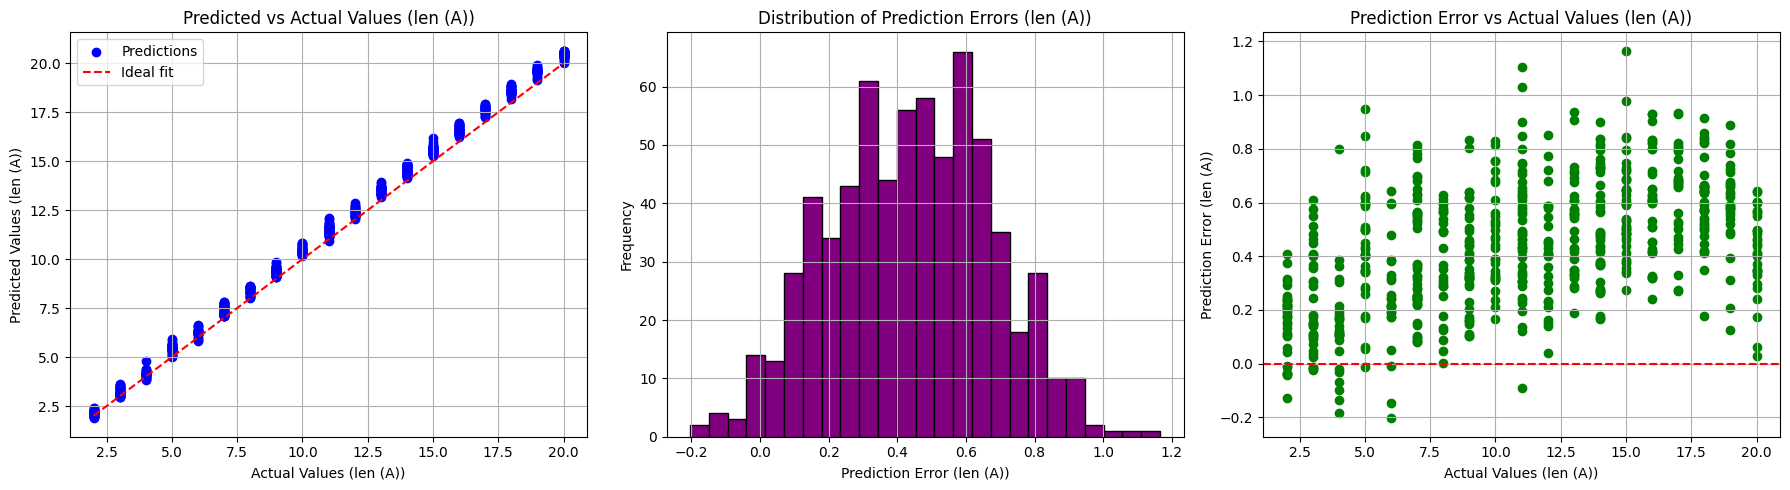

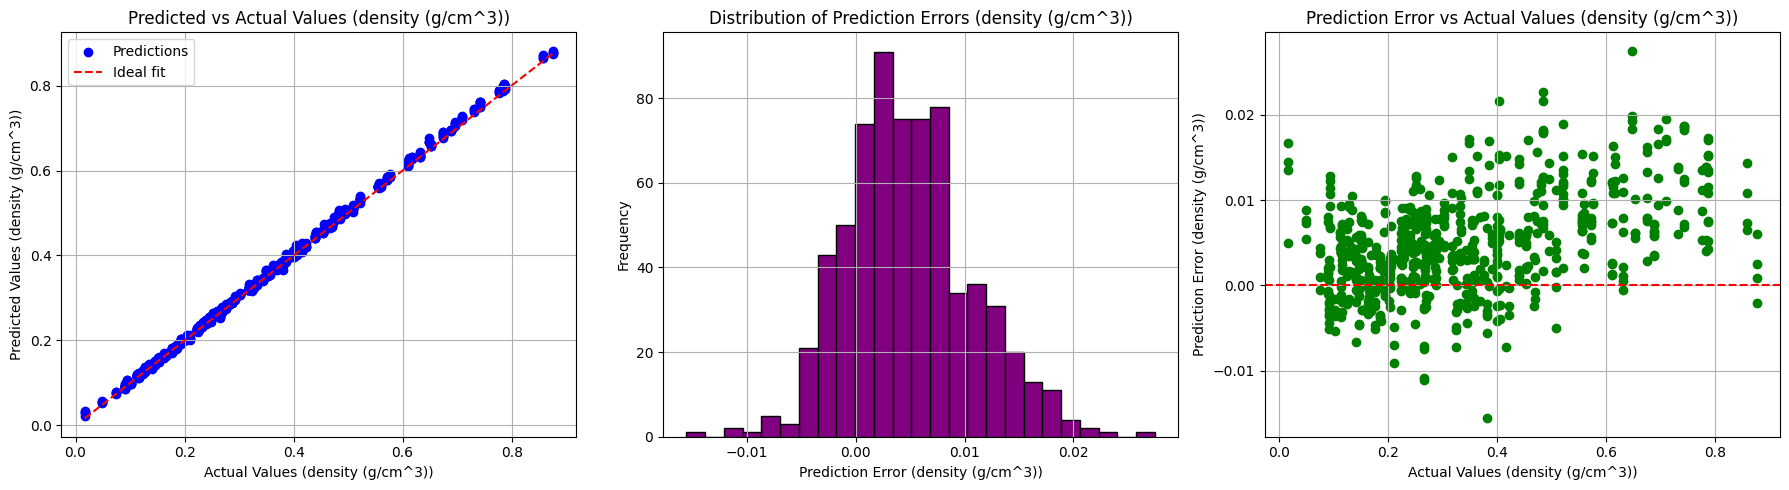

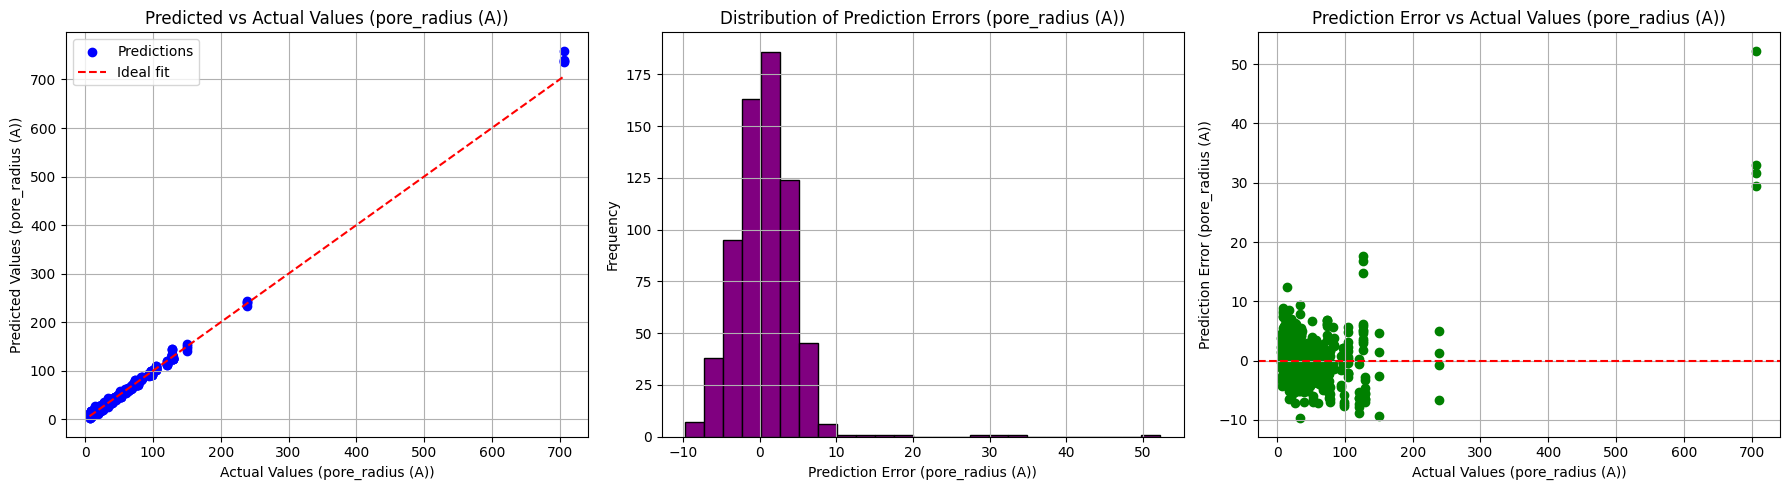

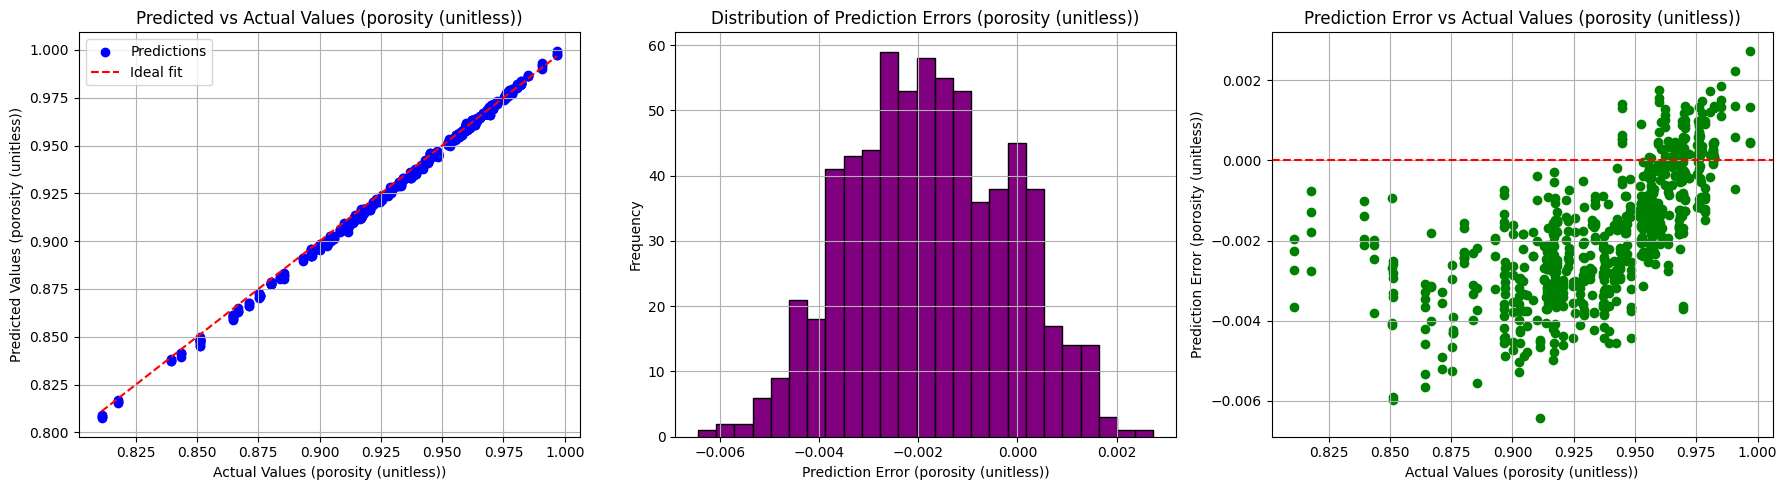

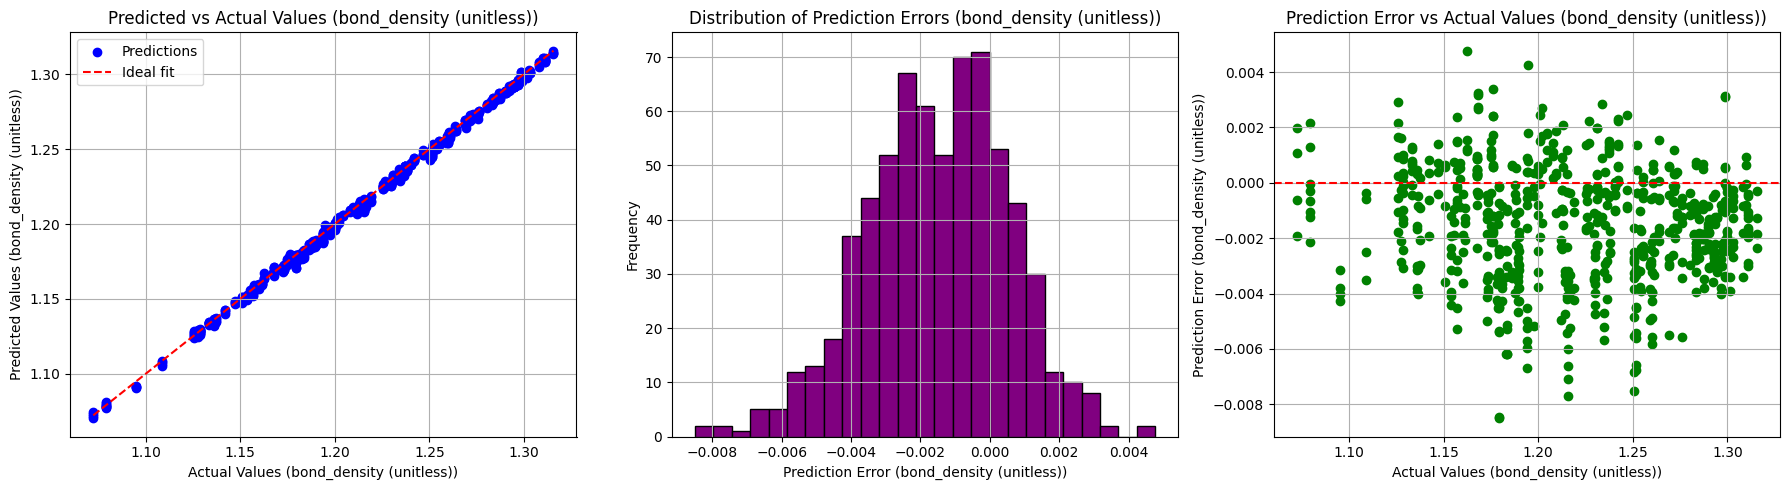

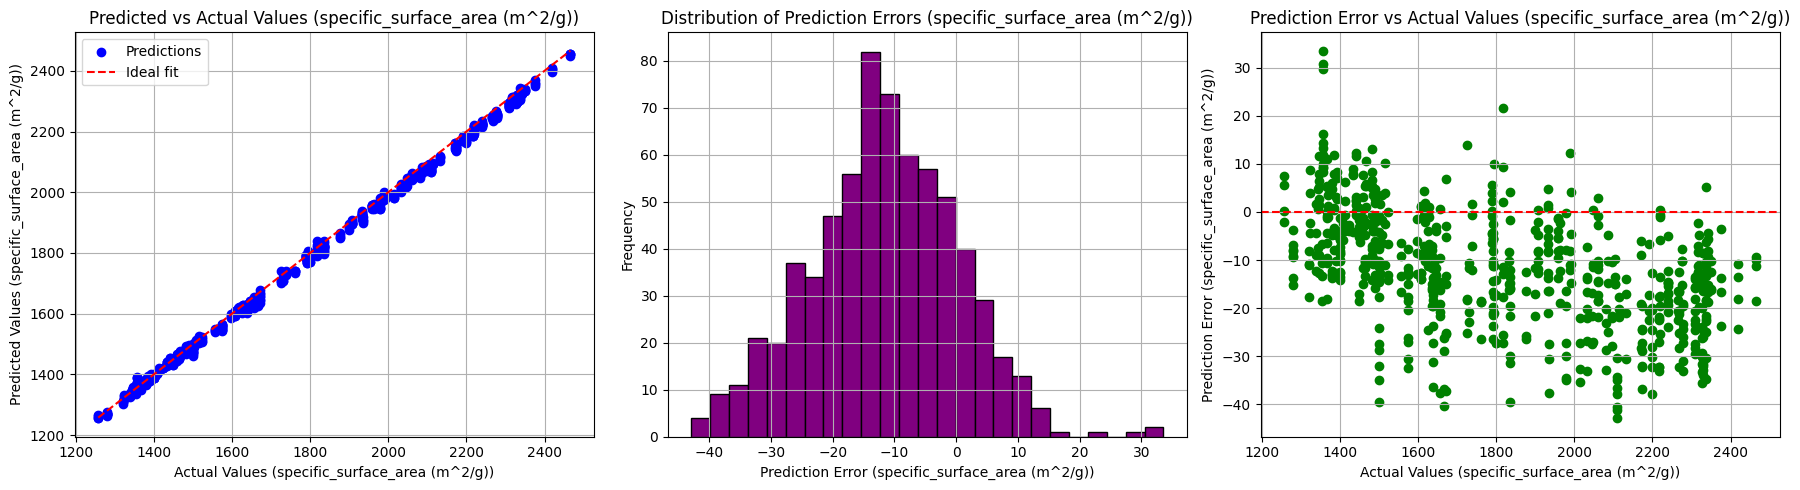

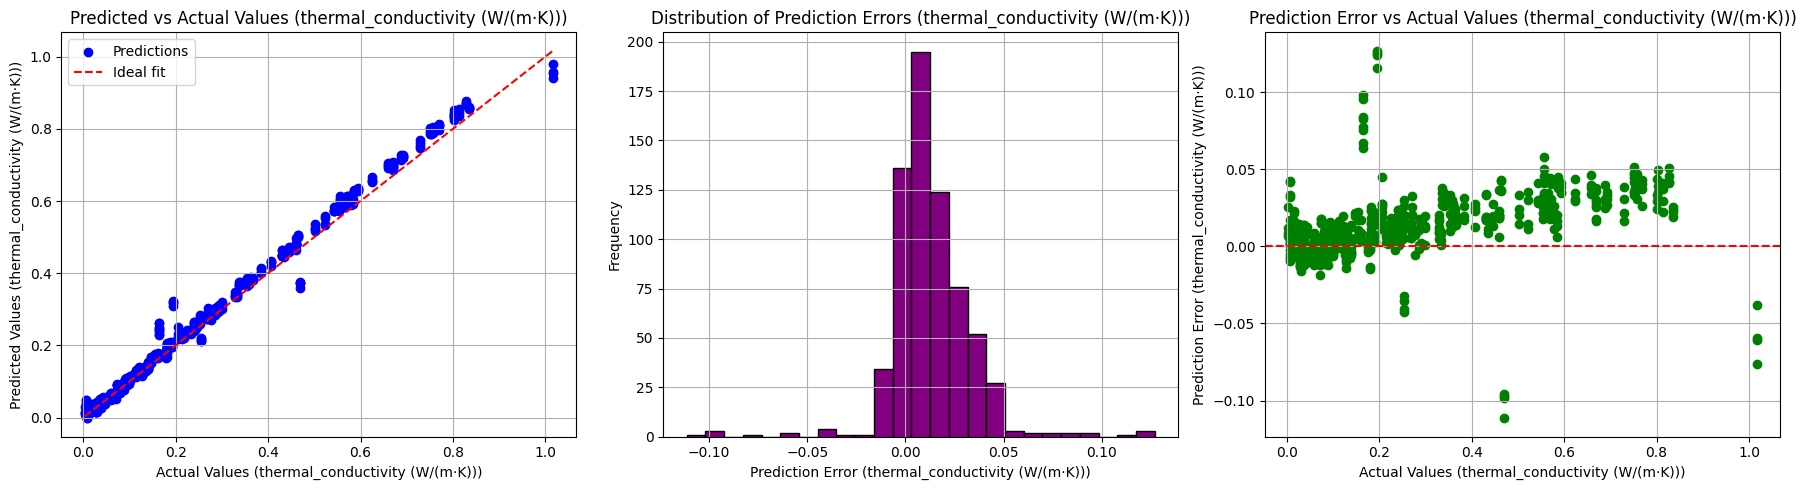

In [56]:
# 调用函数绘制目标值 1 (Target 1)
for idx in range(0,predictions.shape[1]):
  plot_prediction_results(actual_values, predictions, target_idx=idx)

# 10.Save

In [57]:
## Save file ##

# 获取当前时间戳（格式：YYYYMMDD_HHMMSS）
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 获取模型类型
model_type = type(model).__name__  # 提取模型类名，如 "Improved3DCNN"

# 构造文件名
file_name = f"model_results_{model_type}_{timestamp}.pkl"
file_path = f"/content/{file_name}"  # Colab 默认存储路径

# 创建保存字典
results_dict = {
    "predictions": predictions,
    "actual_values": actual_values,
    "scaler": scaler,
    "model": model,
    "trainning_time": trainning_time,
    "reasoning_time": reasoning_time,
    "R2": R2,
    "MSE": MSE,
    "RMSE": RMSE,
    "MAE": MAE,
    "EVS": EVS,
    "MSLE": MSLE,
    "PCC": PCC
}

# 记录开始时间
save_start_time = time.time()

# 保存到文件
with open(file_path, "wb") as f:
    pickle.dump(results_dict, f)

# 记录结束时间
save_end_time = time.time()
save_time = save_end_time - save_start_time

# 获取文件大小
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)

# 打印文件信息
print(f"✅ 结果已保存到 {file_path}")
print(f"💾 文件大小: {file_size_mb:.3f} MB")
print(f"⏳ 保存耗时: {save_time:.4f} 秒")
print(f"📂 下载文件名: {file_name}")



✅ 结果已保存到 /content/model_results_Improved3DCNN_20250303_234550.pkl
💾 文件大小: 513.662 MB
⏳ 保存耗时: 1.2104 秒
📂 下载文件名: model_results_Improved3DCNN_20250303_234550.pkl


In [58]:
## Post Check ##

# 1️⃣ 读取保存的文件
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        loaded_results = pickle.load(f)
    print("✅ 成功加载 model_results.pkl")
else:
    raise FileNotFoundError(f"❌ 未找到文件: {file_path}")

# 2️⃣ 读取变量
expected_keys = [
    "predictions", "actual_values", "scaler", "model",
    "trainning_time", "reasoning_time", "R2", "MSE", "RMSE",
    "MAE", "EVS", "MSLE", "PCC"
]

# 检查是否所有变量都正确存储
missing_keys = [key for key in expected_keys if key not in loaded_results]
if missing_keys:
    print(f"⚠️ 缺少变量: {missing_keys}")
else:
    print("✅ 所有变量均已正确存储！")

# 3️⃣ 测试变量的长度和内容
print("\n📊 变量检查报告")

for key, value in loaded_results.items():
    if isinstance(value, (list, tuple, set)):
        print(f"🔹 {key}: 长度 {len(value)}")
    elif isinstance(value, dict):
        print(f"🔹 {key}: 包含 {len(value.keys())} 个键")
    elif isinstance(value, (int, float, str)):
        print(f"🔹 {key}: 值 {value}")
    else:
        print(f"🔹 {key}: 类型 {type(value)}")

print("\n✅ 核验完成！")

✅ 成功加载 model_results.pkl
✅ 所有变量均已正确存储！

📊 变量检查报告
🔹 predictions: 类型 <class 'numpy.ndarray'>
🔹 actual_values: 类型 <class 'numpy.ndarray'>
🔹 scaler: 类型 <class 'sklearn.preprocessing._data.MinMaxScaler'>
🔹 model: 类型 <class '__main__.Improved3DCNN'>
🔹 trainning_time: 值 1210.537861585617
🔹 reasoning_time: 值 16.717236042022705
🔹 R2: 值 0.9949840275619304
🔹 MSE: 值 0.0002606249598396843
🔹 RMSE: 值 0.01614388304713845
🔹 MAE: 值 0.01156872547067089
🔹 EVS: 值 0.9970746040344238
🔹 MSLE: 值 0.00012050492510878302
🔹 PCC: 值 0.9986228126890708

✅ 核验完成！


In [61]:
# 下载文件（仅限 Google Colab）
from google.colab import files  # 仅在 Google Colab 运行
files.download(file_path)

# 等待10分钟确保下载完成
def pause_execution(minutes=10):
    """
    暂停代码执行指定的分钟数。

    Args:
        minutes (int): 暂停执行的分钟数，默认为 10。
    """
    seconds = minutes * 60  # 将分钟转换为秒
    time.sleep(seconds)  # 使用 time.sleep() 函数暂停执行
    print(f"✅ 已暂停 {minutes} 分钟，继续执行...")

print("开始执行...")
pause_execution()  # 暂停执行 10 分钟
print("继续执行...")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
%%capture
from google.colab import runtime
runtime.unassign()